In [1]:
import numpy as np
np.random.seed(42)
import sklearn
import os
import helper
import keras
import pickle

from keras.layers.advanced_activations import LeakyReLU 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from skimage import exposure

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import matplotlib.pyplot as plt
import random
import statistics
%matplotlib inline
import pandas as pd
% matplotlib inline

import math


import matplotlib.pyplot as plt
import random
import csv
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from skimage import transform as transf
from sklearn.model_selection import train_test_split
import cv2
from prettytable import PrettyTable
%matplotlib inline

SEED = 22

Using TensorFlow backend.


In [5]:
import sklearn
import os

import keras
import pickle
pickle_file_g = 'preprocessed_color.p'


                    

# Reload the data
print(pickle_file_g)
with open(pickle_file_g, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['X_train_color']
    print(len(X_train))
    y_train = pickle_data['y_train']
    X_valid = pickle_data['X_valid_color']
    y_valid = pickle_data['y_valid']
    X_test = pickle_data['X_test_color']
    y_test = pickle_data['y_test']
    X_train_aug = pickle_data['X_train_aug_color']
    y_train_aug = pickle_data['y_train_aug_color']

    del pickle_data  # Free up memory

    print("X_train: ", len(X_train))
    print("y_train: ", len(y_train))
    print("X_valid: ", len(X_valid))
    print("y_valid: ", len(y_valid))
    print("X_test: ", len(X_test))
    print("y_test: ", len(y_test))
    print("X_train_aug: ", len(X_train_aug))
    print("y_train_aug: ", len(y_train_aug))

print('Data and modules loaded.')
print(X_train.shape[1:])
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
    

preprocessed_color.p
39209
X_train:  39209
y_train:  39209
X_valid:  12630
y_valid:  12630
X_test:  12630
y_test:  12630
X_train_aug:  78418
y_train_aug:  78418
Data and modules loaded.
(32, 32, 3)


In [6]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples.
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.bincount(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of validation examples = 12630
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


C:\Users\Sarita Navuluru\ml\capstone\KerasGTSB\helper.py:230: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if class_images[y[i]] == None:


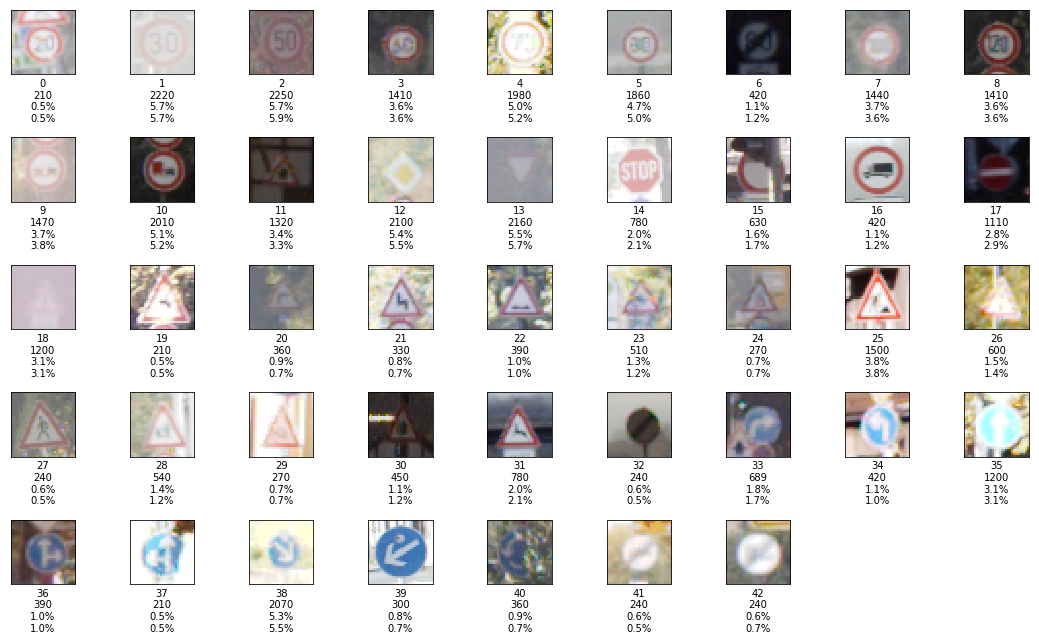

In [7]:
#help(helper)

all_class_images = helper.get_image_per_class(X_train, y_train, n_classes)
#plot_images(0,class_images,9,"")
helper.summarize_stats(all_class_images, y_train, y_valid)

In [8]:
#shuffle
#X_train_color, y_train_color = shuffle(X_train_color, y_train_color, random_state=42)
#X_test_color, y_test_color= shuffle(X_test_color, y_test_color, random_state=42)
#X_valid_color, y_valid_color = shuffle(X_valid_color, y_valid_color, random_state = 42)
#shuffle

#X_train_aug is already shuffled

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test= shuffle(X_test, y_test, random_state=42)
X_valid, y_valid = shuffle(X_valid, y_valid, random_state = 42)


#one-hot-encoding
y_train = np_utils.to_categorical(y_train,num_classes=43)
y_test = np_utils.to_categorical(y_test, num_classes=43)
y_valid = np_utils.to_categorical(y_valid, num_classes=43)
y_train_aug = np_utils.to_categorical(y_valid, num_classes=43)

# Spatial Transformer


In [9]:
from keras.layers.core import Layer
import tensorflow as tf

class SpatialTransformer(Layer):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Borrowed from [2]_:
    downsample_fator : float
        A value of 1 will keep the orignal size of the image.
        Values larger than 1 will down sample the image. Values below 1 will
        upsample the image.
        example image: height= 100, width = 200
        downsample_factor = 2
        output image will then be 50, 100
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
    """

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights
        #self.regularizers = self.locnet.regularizers //NOT SUER ABOUT THIS, THERE IS NO MORE SUCH PARAMETR AT self.locnet
        #self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*(width_float)
        y = .5*(y + 1.0)*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, [-1])
        y_coordinates = tf.reshape(y_coordinates, [-1])
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid
    
    
    def hist_equal(img):
    
        img_eq = exposure.equalize_hist(img)
    return (img_eq) 
    #data_eq = exposure.equalize_hist(dataset)  
    

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?

        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, (batch_size, 3, -1))

        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                                x_s_flatten,
                                                y_s_flatten,
                                                output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                output_height,
                                                                output_width,
                                                                num_channels))
        return transformed_image


In [23]:
input_shape = (32,32,3)


# LOCNET

In [24]:
def locnet():

    # initial weights
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((50, 6), dtype='float32')
    weights = [W, b.flatten()]


    #locnet
    locnet = Sequential()
    locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
    locnet.add(Conv2D(20, (5, 5)))
    locnet.add(MaxPooling2D(pool_size=(2,2)))
    locnet.add(Conv2D(20, (5, 5)))

    locnet.add(Flatten())
    locnet.add(Dense(50))
    locnet.add(LeakyReLU(alpha=0.5))
    locnet.add(Dense(6, weights=weights))
    return locnet
    #locnet.add(Activation('sigmoid'))

#  CNN model 


In [25]:
def cnn_model(flag_BN=False, flag_STN=False):

    
    model = Sequential()
    if flag_STN == True:
        lnet = locnet()
        print(lnet)
        model.add(SpatialTransformer(localization_net=lnet,
                            input_shape=input_shape,output_size=(32,32)))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=input_shape) )                   
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.summary()
    return model

# CNN without Batch  Normalization

In [26]:
model = cnn_model()
# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=20,
                    verbose=1, validation_data=(X_valid, y_valid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
__________

C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 39209 samples, validate on 12630 samples
Epoch 1/20
 1024/39209 [..............................] - ETA: 190s - loss: 3.6904 - acc: 0.0439

KeyboardInterrupt: 

# CNN with  Batch Normalization

In [14]:
model = cnn_model(flag_BN=True)
# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=20,
                    verbose=1, validation_data=(X_valid, y_valid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 64)        256       
__________

C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '



batch_normalization_7 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_8 (Batch (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 1024)              0         
_________

KeyboardInterrupt: 

# STN CNN with BN

In [28]:

model = cnn_model(flag_BN=True,flag_STN=True)

# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=5
                    ,
                    verbose=1, validation_data=(X_valid, y_valid))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_2 (Spati (None, 32, 32, 3)         15896     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        18496     
__________

C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 39209 samples, validate on 12630 samples
Epoch 1/5
 2048/39209 [>.............................] - ETA: 364s - loss: 4.1412 - acc: 0.1206

KeyboardInterrupt: 

# STN CNN capture output 

76.580078125
----------------------------------------
0
12630/12630 [==============================] - 52s    
Epoch: 0 | Valid: [3.2509579184691488, 0.12446555819949363] | Test: [3.2509579184691488, 0.12446555819949363]
0


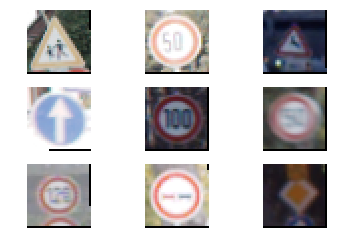

----------------------------------------
0
12630/12630 [==============================] - 74s    
Epoch: 1 | Valid: [3.2074568295799732, 0.074901029300047869] | Test: [3.2074568295799732, 0.074901029300047869]
1


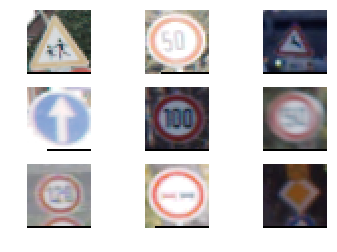

----------------------------------------
0
12630/12630 [==============================] - 82s    
Epoch: 2 | Valid: [3.2478854930315899, 0.046872525737102502] | Test: [3.2478854930315899, 0.046872525737102502]
2


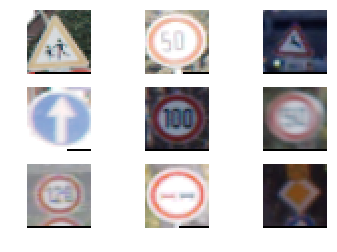

----------------------------------------
0
  352/12630 [..............................] - ETA: 58s

In [30]:
import matplotlib.pyplot as plt
from keras.utils import np_utils, generic_utils

import keras.backend as K
XX = model.input
YY = model.layers[0].output
F = K.function([XX], [YY])

batch_size = 512
print(X_train.shape[0]/batch_size)

nb_epochs = 5 # you probably want to go longer than this
batch_size = 512
fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(10):
            print(b)
            f = b * batch_size
            #print(f)
            l = (b+1) * batch_size
            #print(l)
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            progbar.add(X_batch.shape[0], values=[("train loss", loss[0])])
            #progbar.add(args.batch_size, values=[("train loss", loss[0])])

        scorev = model.evaluate(X_valid, y_valid, verbose=1)
        scoret = model.evaluate(X_test, y_test, verbose=1)
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
        if e % 1 == 0:
            print(e)
            Xresult = F([X_batch[:9]])
            #print(Xresult)
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
        
except KeyboardInterrupt:
    pass

In [31]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

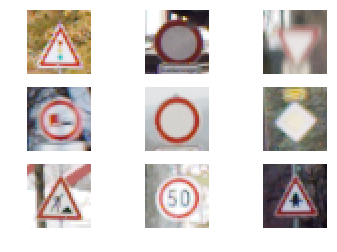

In [32]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

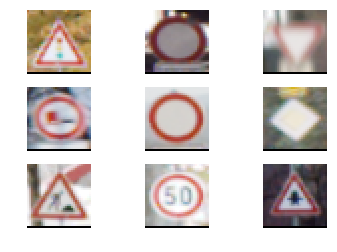

In [33]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')